![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face recognition
Task is to recognize a faces

### Dataset
**Aligned Face Dataset from Pinterest**

This dataset contains 10.770 images for 100 people. All images are taken from 'Pinterest' and      aligned using dlib library.

In [ ]:
pip install tensorflow==2.2

     |████████████████████████████████| 516.2MB 33kB/s 
     |████████████████████████████████| 460kB 47.4MB/s 
     |████████████████████████████████| 3.0MB 45.1MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [ ]:
import tensorflow
tensorflow.__version__

'2.2.0'

#### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Change current working directory to project folder (1 mark)

In [ ]:

import os; os.chdir('drive/My Drive/AIML')

In [ ]:

# Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, sklearn, re, random
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm
import tensorflow, cv2
%matplotlib inline

# Extract content from zipfile
from zipfile import ZipFile

# Model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from sklearn.svm import SVC

# Encode, standardize and PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Set random_state
random_state = 2020

# Suppress warnings, if any
import warnings; warnings.filterwarnings('ignore')

# Print versions
print(f'Pandas version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Scikit-learn version: {sklearn.__version__}')
print(f'Tensorflow version: {tensorflow.__version__}')
print(f'CV version: {cv2.__version__}')

Pandas version: 1.1.2
Numpy version: 1.18.5
Scikit-learn version: 0.22.2.post1
Tensorflow version: 2.2.0
CV version: 4.1.2


### Extract the zip file (2 marks)
- Extract Aligned Face Dataset from Pinterest.zip

In [ ]:
from zipfile import ZipFile


In [ ]:
with ZipFile('Aligned Face.zip', 'r') as zip:
 zip.extractall()

### Function to load images
- Define a function to load the images from the extracted folder and map each image with person id 


In [ ]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')
labels = np.array([meta.name for meta in metadata])

### Define function to load image
- Define a function to load image from the metadata

In [ ]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

#### Load a sample image (2 marks)
- Load one image using the function "load_image"

In [ ]:
n = np.random.randint(1, len(metadata))
img_path = metadata[n].image_path()
img = load_image(img_path)

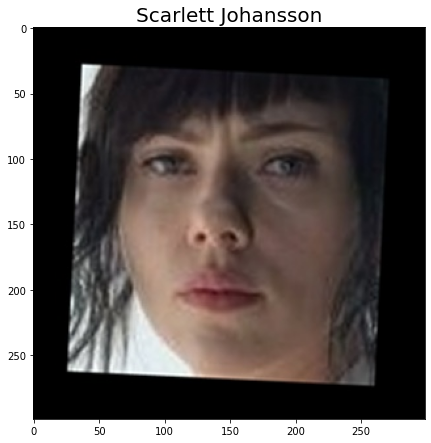

In [ ]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
title = labels[n].split('_')[1]
ax.set_title(title, fontsize = 20)
_ = plt.imshow(img)

### VGG Face model
- Here we are giving you the predefined model for VGG face

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

#### Load the model (2 marks)
- Load the model defined above
- Then load the given weight file named "vgg_face_weights.h5"

In [ ]:
 print(os.getcwd())

/content/drive/My Drive/AIML


In [ ]:
model = vgg_face()
model.load_weights('vgg_face_weights.h5')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

### Get vgg_face_descriptor

In [ ]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

### Generate embeddings for each image in the dataset
- Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model. 

In [ ]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


### Generate embeddings for all images (5 marks)
- Write code to iterate through metadata and create embeddings for each image using `vgg_face_descriptor.predict()` and store in a list with name `embeddings`

- If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [ ]:

embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))
for i, meta in tqdm(enumerate(metadata)):
  try:
    image = load_image(str(meta))
    image = (image/255.).astype(np.float32)
    image = cv2.resize(image, (224, 224))
    embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis = 0))[0]
  except:
    embeddings[i] = np.zeros(2622)

### Function to calculate distance between given 2 pairs of images.

- Consider distance metric as "Squared L2 distance"
- Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

#### Plot images and get distance between the pairs given below
- 2, 3 and 2, 180
- 30, 31 and 30, 100
- 70, 72 and 70, 115

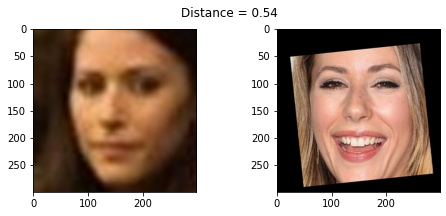

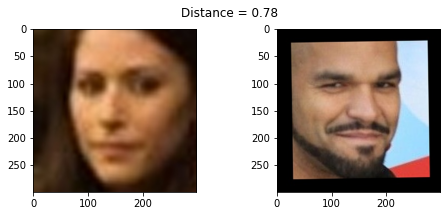

In [ ]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)

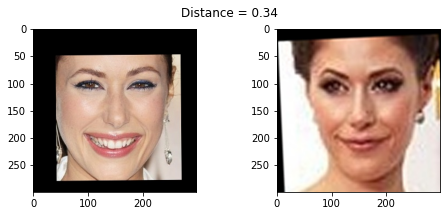

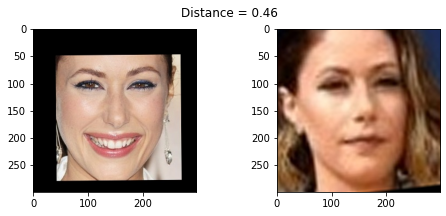

In [ ]:

show_pair(30, 31)
show_pair(30, 100)

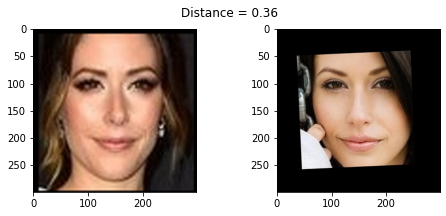

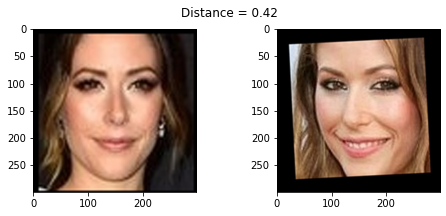

In [ ]:

show_pair(70, 72)
show_pair(70,115)

### Create train and test sets (5 marks)
- Create X_train, X_test and y_train, y_test
- Use train_idx to seperate out training features and labels
- Use test_idx to seperate out testing features and labels

In [ ]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities

X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
#train labels
y_train = targets[train_idx]
#test labels
y_test = targets[test_idx]
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9573, 2622)

(1197, 2622)

(9573,)

(1197,)

In [ ]:
X_test

array([[ 0.00789142,  0.00311657, -0.01063623, ..., -0.00916088,
         0.00381959,  0.01735179],
       [ 0.01963251, -0.02169714, -0.01164608, ..., -0.00385703,
         0.00206622,  0.01777709],
       [ 0.0145785 ,  0.01485331,  0.01445981, ..., -0.02417194,
         0.02114557,  0.03601466],
       ...,
       [ 0.00842342,  0.01685073,  0.00380331, ..., -0.01794228,
         0.01609007,  0.03916249],
       [ 0.01894287,  0.02327758,  0.00159899, ..., -0.02526406,
         0.02352052,  0.02417126],
       [ 0.01420065,  0.0002114 ,  0.00380562, ..., -0.01065842,
         0.02502545,  0.02861988]])

### Encode the Labels (3 marks)
- Encode the targets
- Use LabelEncoder

In [ ]:
from sklearn.preprocessing import LabelEncoder
en=LabelEncoder()
y_train = en.fit_transform(y_train)
y_test = en.transform(y_test)

### Standardize the feature values (3 marks)
- Scale the features using StandardScaler

In [ ]:
# Standarize features
from sklearn.preprocessing import StandardScaler


# Standarize features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

### Reduce dimensions using PCA (3 marks)
- Reduce feature dimensions using Principal Component Analysis
- Set the parameter n_components=128

In [ ]:
pca = PCA(n_components=128)
pca.fit(X_train_sc.T)

PCA(copy=True, iterated_power='auto', n_components=128, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
print(pca.explained_variance_)

[1294.92965887  514.601183    383.85924201  353.32668816  325.86091679
  300.28289423  247.95246865  223.9382753   201.0750442   186.68363513
  174.27087891  162.71952276  158.19848134  149.41095339  135.84660231
  130.8458186   124.84125905  117.70933618  111.12096844  108.71990817
  104.16709324  100.89752519   92.49323824   89.63247113   87.44835515
   84.58416584   79.82755422   73.14752351   72.52240017   70.6334122
   66.8385367    63.90687999   60.6238208    59.69529893   54.7127189
   50.92948896   50.24358539   49.25456439   48.21542047   46.77040546
   42.17881845   41.67830365   38.07187747   37.87173799   35.5525899
   33.9951238    32.63966623   31.93773467   31.38374171   30.6674514
   30.13802301   29.37336582   27.75178749   27.13180524   26.52081962
   26.16923172   25.63952734   25.03115217   24.30975604   23.84203728
   22.68561958   22.27261759   21.53691489   20.83507223   20.17915918
   19.65959095   19.29084859   18.75514796   18.01702783   17.71972054
   17.4781

In [ ]:
# Covariance matrix
cov_matrix = np.cov(X_train_sc.T)

# Eigen values and vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Cumulative variance explained
tot = sum(eig_vals)
var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)


print('Cumulative Variance Explained', cum_var_exp)

Cumulative Variance Explained [ 13.57068937  18.95189341  22.96038134 ...  99.99999983  99.99999999
 100.        ]


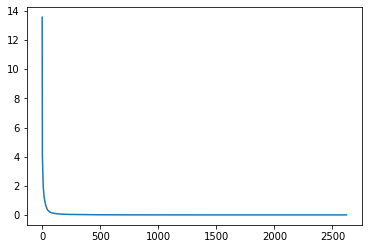

In [ ]:
plt.plot(var_exp)

In [ ]:
# Step 2- Get eigen values and eigen vector
print('Eigen Vectors \n%s', eig_vecs)
print('\n Eigen Values \n%s', eig_vals)

Eigen Vectors 
%s [[-0.02391635  0.02057846 -0.00289402 ... -0.00860421 -0.00268119
   0.00160917]
 [ 0.00895625 -0.00087517 -0.00258085 ... -0.02743724 -0.0028272
  -0.01542268]
 [-0.00328484  0.00864778  0.00526252 ... -0.01600379  0.01134238
   0.0016612 ]
 ...
 [-0.00825687 -0.02365032 -0.00956647 ... -0.02548927  0.02057856
   0.01583129]
 [ 0.02127501 -0.00380545 -0.00017929 ...  0.0095814   0.0082755
  -0.00524471]
 [ 0.03885103  0.01121543  0.01524405 ...  0.00390833  0.03238716
   0.01731131]]

 Eigen Values 
%s [3.55860649e+02 1.41109910e+02 1.05113534e+02 ... 1.58764080e-03
 1.58555335e-03 1.53568078e-03]


In [ ]:
# Get index where cumulative variance explained is > threshold
thres = 95
res = list(filter(lambda i: i > thres, cum_var_exp))[0]
index = (cum_var_exp.tolist().index(res))
print(f'Index of element just greater than {thres}: {str(index)}')

Index of element just greater than 95: 347


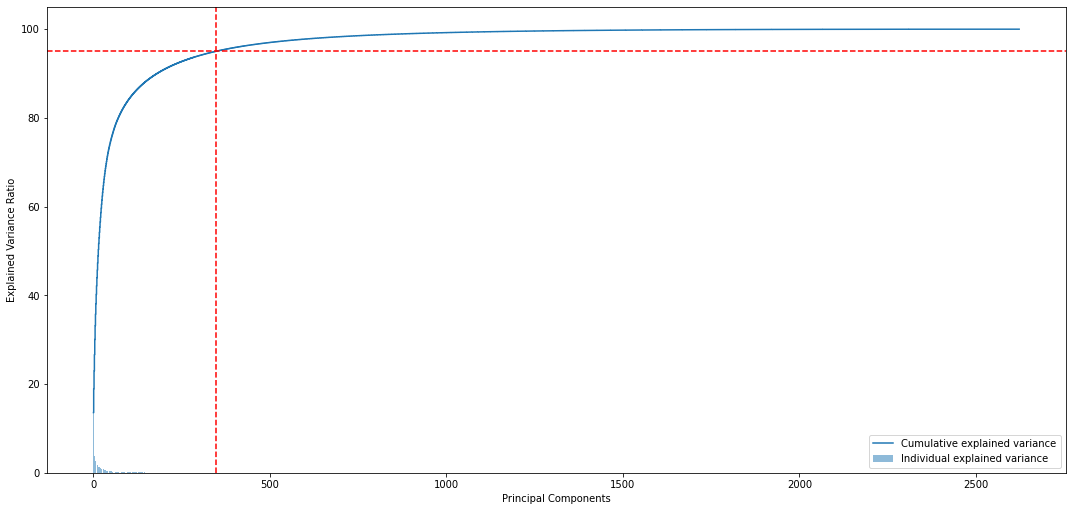

In [ ]:

# Ploting 
plt.figure(figsize = (15 , 7.2))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
plt.axhline(y = thres, color = 'r', linestyle = '--')
plt.axvline(x = index, color = 'r', linestyle = '--')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [ ]:
# Reducing the dimensions
pca = PCA(n_components = 128, random_state = random_state, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
display(X_train_pca.shape, X_test_pca.shape)

(9573, 128)

(1197, 128)

In [ ]:
print(pca.components_)

[[-0.02391635  0.00895625 -0.00328484 ... -0.00825687  0.02127501
   0.03885103]
 [ 0.02057846 -0.00087517  0.00864778 ... -0.02365032 -0.00380545
   0.01121543]
 [ 0.00289402  0.00258085 -0.00526252 ...  0.00956647  0.00017929
  -0.01524405]
 ...
 [ 0.03297436 -0.04417677 -0.01148154 ...  0.00872243  0.00486637
  -0.01821682]
 [ 0.02491241  0.00788799  0.00665866 ...  0.01570256  0.0295101
   0.04101693]
 [-0.0019558   0.00034049  0.01078502 ... -0.00367582  0.03459417
   0.0155496 ]]


In [ ]:
print(pca.explained_variance_ratio_)

[0.13570689 0.05381204 0.04008488 0.03690071 0.03402933 0.03135649
 0.02589187 0.02338453 0.02099823 0.01950212 0.0181975  0.01699223
 0.01652144 0.01560167 0.01418971 0.01366454 0.01303608 0.01229149
 0.01160345 0.01135412 0.01087722 0.01053581 0.00965821 0.00936185
 0.00913148 0.00883245 0.00833566 0.00763834 0.00757321 0.00737562
 0.0069794  0.00667363 0.00633176 0.006234   0.00571329 0.00531811
 0.00524683 0.00514346 0.00503525 0.00488392 0.00440434 0.00435214
 0.00397581 0.00395477 0.00371246 0.00354995 0.00340859 0.00333499
 0.00327711 0.00320233 0.00314706 0.00306728 0.00289815 0.00283326
 0.00276932 0.00273283 0.00267736 0.00261382 0.00253857 0.00248987
 0.00236887 0.00232575 0.00224894 0.00217584 0.00210712 0.00205287
 0.00201438 0.00195842 0.00188136 0.00185043 0.00182516 0.00178321
 0.00174833 0.00173907 0.00170149 0.00166203 0.00163362 0.00161919
 0.00156502 0.00156124 0.00151634 0.00149526 0.00146529 0.00142741
 0.00140368 0.00138728 0.00136961 0.00133619 0.00132637 0.0012

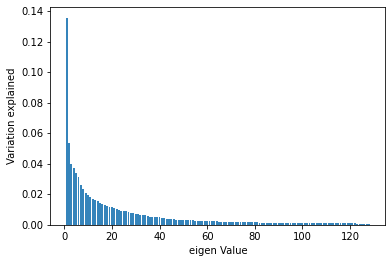

In [ ]:
plt.bar(list(range(1,129)),pca.explained_variance_ratio_,alpha=0.9, align='center')
plt.ylabel('Variation explained')
plt.xlabel('eigen Value')
plt.show()

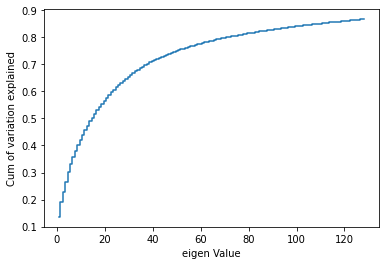

In [ ]:
plt.step(list(range(1,129)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

### Build a Classifier (3 marks)
- Use SVM Classifier to predict the person in the given image
- Fit the classifier and print the score

In [ ]:

svc_pca = SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced', random_state = 2020)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 0.975


In [ ]:

# Predict
y_pred = svc_pca.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(3)))

Accuracy Score: 0.952


In [ ]:
names = [name.split('_')[1].title().strip() for name in labels]

# Classification Report
print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, target_names = np.unique(names))))

Classification Report: 
                          precision    recall  f1-score   support

              Aaron Paul       1.00      1.00      1.00        10
      Alexandra Daddario       1.00      1.00      1.00        10
            Alvaro Morte       1.00      1.00      1.00        14
Alycia Debnam Carey Face       1.00      1.00      1.00        12
             Amanda Crew       1.00      0.86      0.92         7
          Amaury Nolasco       1.00      0.89      0.94         9
        Amber Heard Face       1.00      1.00      1.00         8
               Anna Gunn       0.92      0.79      0.85        14
           Anne Hathaway       1.00      1.00      1.00        14
     Barbara Palvin Face       0.82      1.00      0.90         9
      Bellamy Blake Face       0.93      0.93      0.93        14
    Benedict Cumberbatch       0.92      0.92      0.92        12
            Betsy Brandt       1.00      0.90      0.95        10
              Bill Gates       1.00      1.00      

### Test results (1 mark)
- Take 10th image from test set and plot the image
- Report to which person(folder name in dataset) the image belongs to

In [ ]:
def sample_img_plot(sample_idx):
  # Load image for sample_idx from test data
  sample_img = load_image(metadata[test_idx][sample_idx].image_path())
  # Get actual name
  actual_name = metadata[test_idx][sample_idx].name.split('_')[-1].title().strip()
  # Normalizing pixel values
  sample_img = (sample_img/255.).astype(np.float32)
  # Resize
  sample_img = cv2.resize(sample_img, (224, 224))

  # Obtain embedding vector for sample image
  embedding = vgg_face_descriptor.predict(np.expand_dims(sample_img, axis = 0))[0]
  # Scaled the vector and reshape
  embedding_scaled = sc.transform(embedding.reshape(1, -1))
  # Predict
  sample_pred = svc_pca.predict(pca.transform(embedding_scaled))
  # Transform back
  pred_name = en.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return sample_img, actual_name, pred_name

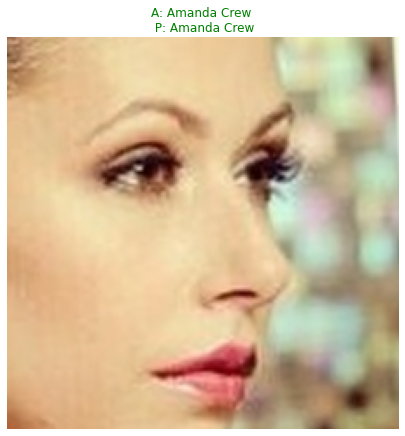

In [ ]:
# Plot for 10th image in test data
sample_img, actual_name, pred_name = sample_img_plot(10)
fig = plt.figure(figsize = (15, 7.2))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

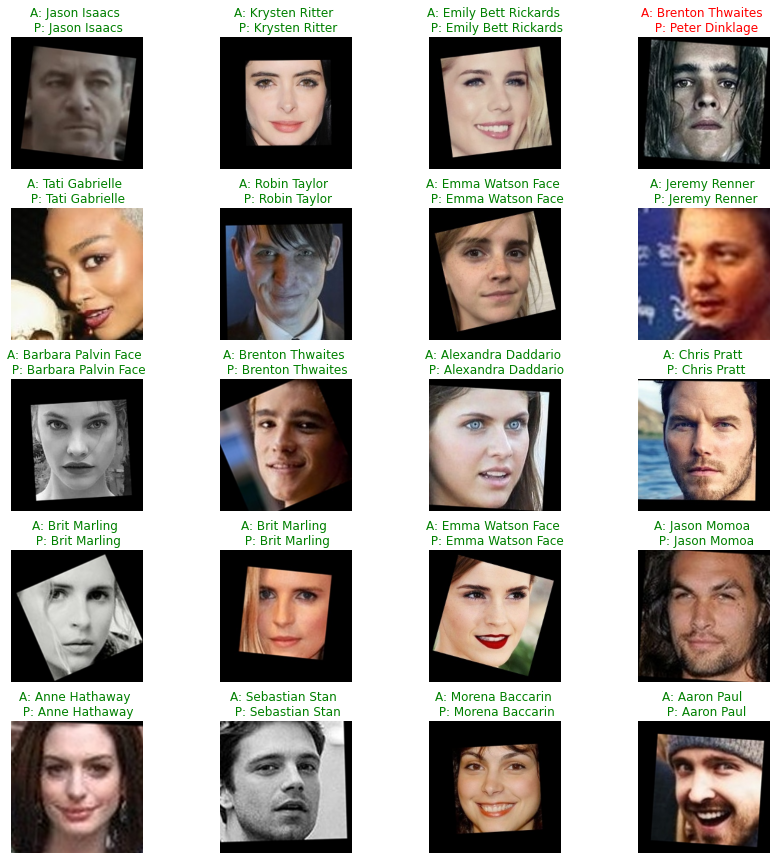

In [ ]:

# Random 20 sample images from test data
plt.figure(figsize = (15, 15))
gs1 = gridspec.GridSpec(5, 4)
gs1.update(wspace = 0, hspace = 0.3) 

for i in range(20):
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    
    sample_img, actual_name, pred_name = sample_img_plot(random.randint(1, 1197))
  
    plt.axis('off')
    plt.imshow(sample_img)
  
    plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()


# Conclusion
Task here was to recognize (aligned) faces from a dataset containing 10k+ images for 100 people using a pre-trained model on Face Recognition.

VGG model with pre-trained weights was used to generate embeddings for each images in the dataset.
Distance between two pair of images were also calculated and plotted.
Since, there were 2,622 features for each image, PCA was used for dimension reduction after standardizing the features.
With an cumulative explained variance of 95%, 347 PCA components were used.
Using SVC we predicted the labels for test dataset with an accuracy of more than 96%.
Also compared predicted and actual labels for a given sample image as well as for 20 random images from test dataset.